## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""

def build_mlp(input_shape, regular, ratio, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    print(ratio)
    if regular == 0:
            
        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=l1(ratio))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1(ratio))(x)
                
    elif regular == 1:
        
        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=l1_l2(l1=ratio[0],l2=ratio[1]))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1_l2(l1=ratio[0],l2=ratio[1]))(x)

    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    
    return model

In [6]:
"""Code Here
設定超參數
"""

## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
l1_list = [1e-2, 1e-4, 1e-8]
l1_l2_list = [ [1e-2,1e-2], [1e-4,1e-4], [1e-8,1e-8] ]


In [7]:
results = {}

"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

ii = 0
    
for regularizer_ratio in l1_list:
    keras.backend.clear_session() # 把舊的 Graph 清掉

    print("Experiment with regularizer = %.6f" % (regularizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], regular=ii,ratio=regularizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]


    exp_name_tag = "exp-l1-" + str(regularizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}   


Experiment with regularizer = 0.010000
0.01
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/5000

50000/50000 [==============================] - 11s 214us/step - loss: 2.4626 - accuracy: 0.0960 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 12s 234us/step - loss: 2.4626 - accuracy: 0.1000 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 13s 254us/step - loss: 2.4626 - accuracy: 0.0958 - val_loss: 2.4626 - val_accuracy: 0.1000
Experiment with regularizer = 0.000100
0.0001
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_____________________________________

50000/50000 [==============================] - 9s 185us/step - loss: 2.8215 - accuracy: 0.6230 - val_loss: 3.3438 - val_accuracy: 0.4654
Epoch 46/50
50000/50000 [==============================] - 10s 191us/step - loss: 2.7946 - accuracy: 0.6196 - val_loss: 3.0495 - val_accuracy: 0.5274
Epoch 47/50
50000/50000 [==============================] - 9s 179us/step - loss: 2.7476 - accuracy: 0.6237 - val_loss: 3.0291 - val_accuracy: 0.5219
Epoch 48/50
50000/50000 [==============================] - 9s 179us/step - loss: 2.7077 - accuracy: 0.6238 - val_loss: 2.9473 - val_accuracy: 0.5421
Epoch 49/50
50000/50000 [==============================] - 9s 184us/step - loss: 2.6725 - accuracy: 0.6274 - val_loss: 2.9371 - val_accuracy: 0.5318
Epoch 50/50
50000/50000 [==============================] - 9s 188us/step - loss: 2.6374 - accuracy: 0.6272 - val_loss: 3.1904 - val_accuracy: 0.4610
Experiment with regularizer = 0.000000
1e-08
Model: "model_1"
_______________________________________________________

50000/50000 [==============================] - 8s 165us/step - loss: 0.9485 - accuracy: 0.6677 - val_loss: 1.4109 - val_accuracy: 0.5107
Epoch 43/50
50000/50000 [==============================] - 8s 165us/step - loss: 0.9335 - accuracy: 0.6732 - val_loss: 1.4513 - val_accuracy: 0.5112
Epoch 44/50
50000/50000 [==============================] - 8s 167us/step - loss: 0.9175 - accuracy: 0.6800 - val_loss: 1.3770 - val_accuracy: 0.5326
Epoch 45/50
50000/50000 [==============================] - 8s 165us/step - loss: 0.9109 - accuracy: 0.6811 - val_loss: 1.4046 - val_accuracy: 0.5232
Epoch 46/50
50000/50000 [==============================] - 8s 165us/step - loss: 0.8986 - accuracy: 0.6854 - val_loss: 1.3772 - val_accuracy: 0.5324
Epoch 47/50
50000/50000 [==============================] - 8s 165us/step - loss: 0.8839 - accuracy: 0.6900 - val_loss: 1.4041 - val_accuracy: 0.5347
Epoch 48/50
50000/50000 [==============================] - 9s 178us/step - loss: 0.8757 - accuracy: 0.6952 - val_loss:

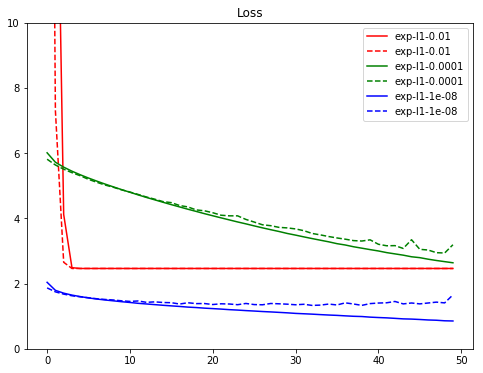

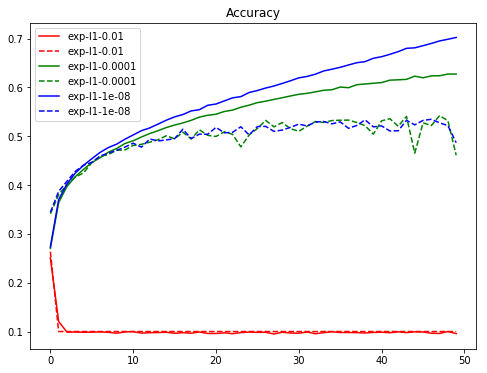

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 10])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [12]:
results1 = {}
ii = 1
    
for regularizer_ratio in l1_l2_list:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with regularizer = " + str(regularizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], regular=ii, ratio=regularizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]


    exp_name_tag = "exp-l1-l2-" + str(regularizer_ratio)
    results1[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with regularizer = [0.01, 0.01]
[0.01, 0.01]
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/5

50000/50000 [==============================] - 9s 189us/step - loss: 2.4614 - accuracy: 0.0971 - val_loss: 2.4614 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 9s 189us/step - loss: 2.4614 - accuracy: 0.0969 - val_loss: 2.4613 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 10s 197us/step - loss: 2.4614 - accuracy: 0.0987 - val_loss: 2.4613 - val_accuracy: 0.1000
Experiment with regularizer = [0.0001, 0.0001]
[0.0001, 0.0001]
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_____________________

50000/50000 [==============================] - 10s 198us/step - loss: 2.8135 - accuracy: 0.6121 - val_loss: 2.9929 - val_accuracy: 0.5402
Epoch 46/50
50000/50000 [==============================] - 10s 203us/step - loss: 2.7668 - accuracy: 0.6156 - val_loss: 3.0170 - val_accuracy: 0.5225
Epoch 47/50
50000/50000 [==============================] - 10s 202us/step - loss: 2.7294 - accuracy: 0.6164 - val_loss: 3.0372 - val_accuracy: 0.5070
Epoch 48/50
50000/50000 [==============================] - 10s 202us/step - loss: 2.6885 - accuracy: 0.6195 - val_loss: 3.0573 - val_accuracy: 0.4969
Epoch 49/50
50000/50000 [==============================] - 10s 201us/step - loss: 2.6524 - accuracy: 0.6190 - val_loss: 2.8722 - val_accuracy: 0.5338
Epoch 50/50
50000/50000 [==============================] - 10s 200us/step - loss: 2.6152 - accuracy: 0.6195 - val_loss: 2.8588 - val_accuracy: 0.5324
Experiment with regularizer = [1e-08, 1e-08]
[1e-08, 1e-08]
Model: "model_1"
___________________________________

50000/50000 [==============================] - 10s 197us/step - loss: 0.9664 - accuracy: 0.6601 - val_loss: 1.3774 - val_accuracy: 0.5282
Epoch 43/50
50000/50000 [==============================] - 10s 200us/step - loss: 0.9521 - accuracy: 0.6664 - val_loss: 1.3884 - val_accuracy: 0.5193
Epoch 44/50
50000/50000 [==============================] - 10s 198us/step - loss: 0.9450 - accuracy: 0.6681 - val_loss: 1.3661 - val_accuracy: 0.5292
Epoch 45/50
50000/50000 [==============================] - 11s 228us/step - loss: 0.9303 - accuracy: 0.6748 - val_loss: 1.4032 - val_accuracy: 0.5237
Epoch 46/50
50000/50000 [==============================] - 10s 203us/step - loss: 0.9141 - accuracy: 0.6791 - val_loss: 1.3474 - val_accuracy: 0.5377
Epoch 47/50
50000/50000 [==============================] - 10s 202us/step - loss: 0.9052 - accuracy: 0.6812 - val_loss: 1.4138 - val_accuracy: 0.5204
Epoch 48/50
50000/50000 [==============================] - 10s 198us/step - loss: 0.8947 - accuracy: 0.6880 - va

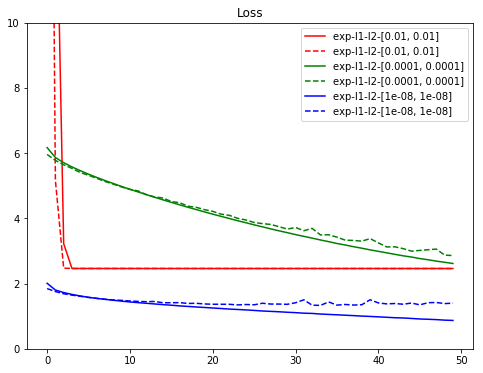

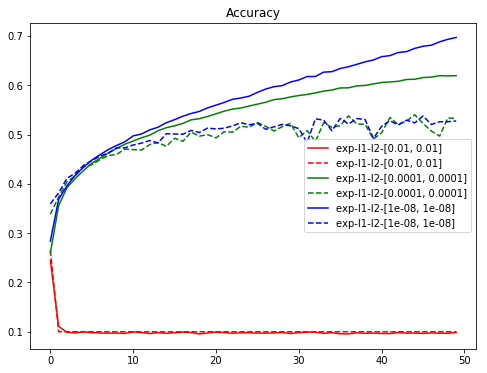

In [14]:
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results1.keys()):
    plt.plot(range(len(results1[cond]['train-loss'])),results1[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results1[cond]['valid-loss'])),results1[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 10])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results1.keys()):
    plt.plot(range(len(results1[cond]['train-acc'])),results1[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results1[cond]['valid-acc'])),results1[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()